# SALES PREDICTION USING SARIMAX FOR BRAZILIAN E-COMMERCE

The dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

**What is ARIMA model?**

A. ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

# 📤 IMPORT LIBRARIES

In [1]:
!pip install statsmodels
!pip install pmdarima
!pip install pandas-profiling

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
from pandas.plotting import autocorrelation_plot
from scipy import stats
import os
import itertools

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
pd.set_option('display.max_columns', 100)
from viz_utils import *

import seaborn as sns
import statsmodels.api as sm

from pylab import rcParams

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX, AutoReg
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt


# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings('ignore')


In [3]:
#Functions

def mean_absolute_percentage_error(actual, pred):
    return np.mean(np.abs((actual - pred) / actual))

def ml_error(model_name, actual, pred):
    r2=r2_score(actual, pred)
    mae = mean_absolute_error(actual, pred)
    mape = mean_absolute_percentage_error(actual, pred)
    rmse = sqrt(mean_squared_error(actual, pred))
    mse = ((actual- pred) ** 2).mean()
   
#rmse = np.sqrt(mean_squared_error(actual, pred))

    return pd.DataFrame({'Model Name' : model_name,
                        'r2': r2,
                        'MAE' : mae,
                        'MAPE' : mape,
                        'RMSE' : rmse,
                        'MSE' : mse}, index = [0])

# 💾 CHECK OUT THE DATA

**IMPORTING AWS S3 BUCKET FILES**

In [4]:
orders = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_orders_dataset.csv"
customer = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_customers_dataset.csv"
item = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_order_items_dataset.csv"
products = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_products_dataset.csv"
sellers = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_sellers_dataset.csv"
order_pay = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_order_payments_dataset.csv"
category ="https://stack-labs-landing.s3.amazonaws.com/datasets/product_category_name_translation.csv"

In [5]:
df_orders = pd.read_csv(orders)
df_customers = pd.read_csv(customer)
df_item = pd.read_csv(item)
df_products = pd.read_csv(products)
df_sellers = pd.read_csv(sellers)
df_order_pay = pd.read_csv(order_pay)
df_category = pd.read_csv(category)

**MERGE DF_ORDERS WITH DF_CUSTOMERS**

In [6]:
df_orders = df_orders.merge(df_customers, on='customer_id', how='outer')

**ALL IN ONE**

In [7]:
# merge all the tables in one dataframe
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

# Using Pandas Profiling

In [8]:
#pp.ProfileReport(df_train)

In [9]:
#This data from the train table will be used for the prediction of the price, which here we will call as total sales.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118434 entries, 0 to 118433
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   customer_unique_id             118434 non-null  object 
 9   customer_zip_code_prefix       118434 non-null  int64  
 10  customer_city                  118434 non-null  object 
 11  customer_state                 118434 non-null  object 
 12  order_item_id                 

In [10]:
pd.value_counts(df_train['price'])

59.90     2606
69.90     2092
49.90     2045
89.90     1623
99.90     1510
          ... 
96.50        1
135.65       1
75.40        1
35.94        1
789.89       1
Name: price, Length: 5968, dtype: int64

**CLEAN DATA**

In [11]:
#Counting number of empty rows in the df_orders
df_orders.isnull().sum().sort_values(ascending = False)

order_delivered_customer_date    2965
order_delivered_carrier_date     1783
order_approved_at                 160
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [12]:
#Counting number of empty rows in the df_train
df_train.isnull().sum().sort_values(ascending = False)

order_delivered_customer_date    3397
product_photos_qty               2528
product_description_lenght       2528
product_name_lenght              2528
product_category_name            2528
order_delivered_carrier_date     2074
product_width_cm                  850
product_height_cm                 850
product_length_cm                 850
product_weight_g                  850
price                             830
shipping_limit_date               830
seller_city                       830
seller_zip_code_prefix            830
freight_value                     830
seller_state                      830
product_id                        830
order_item_id                     830
seller_id                         830
order_approved_at                 176
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
customer_id                         0
order_estimated_delivery_date       0
order_status

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118434 entries, 0 to 118433
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   customer_unique_id             118434 non-null  object 
 9   customer_zip_code_prefix       118434 non-null  int64  
 10  customer_city                  118434 non-null  object 
 11  customer_state                 118434 non-null  object 
 12  order_item_id                 

**Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?**

# **EXPLORATORY DATA ANALYSIS**

# **Visualization E-commerce Price Overtime**

# Price Distribution

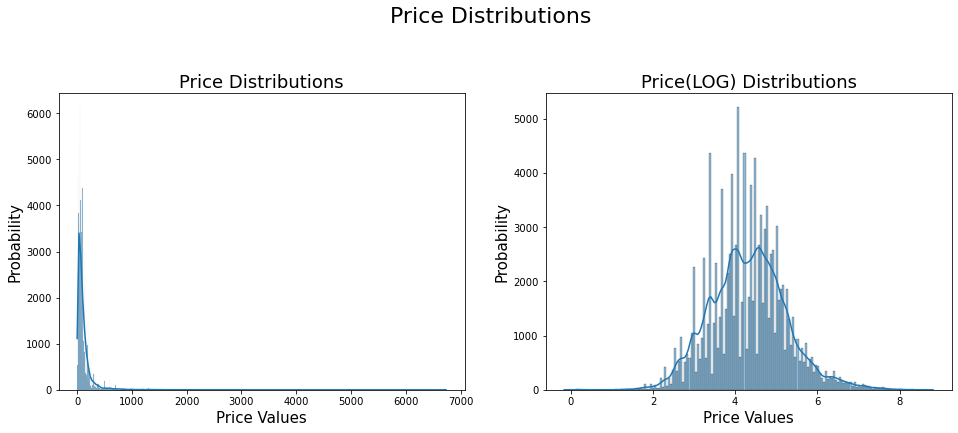

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


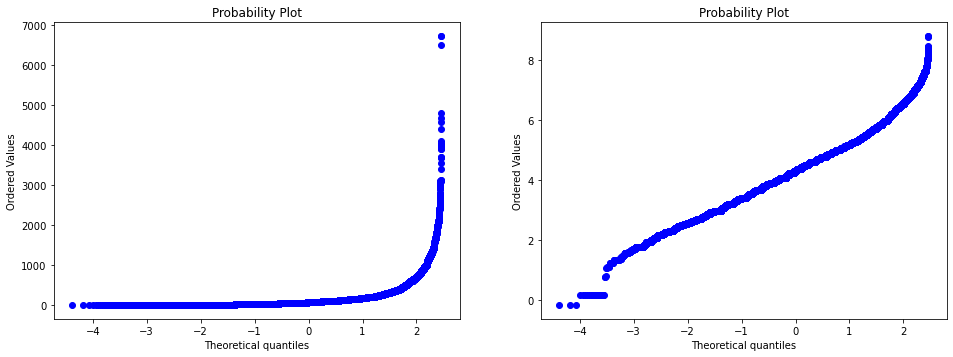

In [14]:
# Getting the histogram and normal probability plot
plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.histplot(df_train['price'], kde=True)
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df_train['price']), kde=True)
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

plt.figure(figsize=(16,12))

plt.subplot(221)
res = stats.probplot(df_train['price'], plot=plt, fit=True, rvalue=True);

plt.subplot(222)
res = stats.probplot(np.log(df_train['price']), plot=plt, fit=True, rvalue=True);

plt.show()

Price Distribution: Histogram of a sample from a right-skewed distribution – it looks unimodal and skewed right.

Price Log Distribution: Histogram of a sample from a normal distribution – it looks fairly symmetric and unimodal.

Probability Plot - Price Distribution: Normal probability plot of a sample from a right-skewed distribution – it has an inverted C shape.

Probability Plot - Price Log Distribution: Normal probability plot of a sample from a normal distribution – it looks fairly straight, at least when the few large and small values are ignored.

# Visualization E-commerce Orders Overtime

# Evolution of E-Commerce Overtime - Amount of orders

CONVERT DATE COLUMNS TO TIMESTAMP

In [15]:
# Changing the datetime features to the correct format
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])

#Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
#df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))


df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m-%d'))

# Extracting attributes for purchase date - Year and Week
df_orders['order_purchase_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.week)
df_orders['order_purchase_year_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%U'))


# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))


# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_year_month,order_purchase_date,order_purchase_week,order_purchase_year_week,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,2017-10,2017-10-02,40,2017-40,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,2018-08-07 15:27:00,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,2018-07,2018-07-24,30,2018-29,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,2018-08-17 18:06:00,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,2018-08,2018-08-08,32,2018-31,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,2017-11-18 19:45:00,2017-11-22 13:39:00,2017-12-02 00:28:00,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,2017-11,2017-11-18,46,2017-46,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,2018-02-13 22:20:00,2018-02-14 19:46:00,2018-02-16 18:17:00,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,2018-02,2018-02-13,7,2018-06,13,1,Tue,21,Night


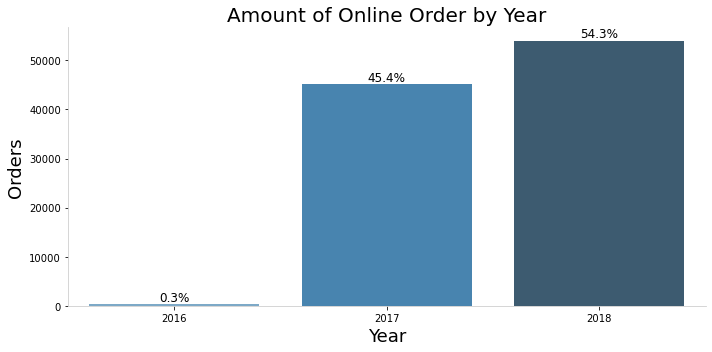

In [16]:
# Preparing the chart
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_year', data=df_orders, palette='Blues_d')
format_spines(ax, right_border=False)

# Showing frequency
ncount = len(df_orders)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom', size=12)

ax.set_title('Amount of Online Order by Year', size=20)
ax.set_ylabel('Orders', size=18)
ax.set_xlabel('Year', size=18)

plt.tight_layout()
plt.show()

The number of orders in 2016 was insignificant, only 0,3% of the total.

Then, we selected the period of interest to try a better performance in the model

# **Evolution of E-Commerce Overtime - Total Sales per day**

In [17]:
df_sale = df_train.groupby('order_purchase_timestamp')['price'].sum().reset_index()
df_sale['order_purchase_timestamp'] = pd.to_datetime(df_sale['order_purchase_timestamp'])
df_sale = df_sale.sort_values('order_purchase_timestamp')
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88789 entries, 88086 to 8468
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_purchase_timestamp  88789 non-null  datetime64[ns]
 1   price                     88789 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 MB


**Analyzing the outliers**

<Figure size 1800x720 with 0 Axes>

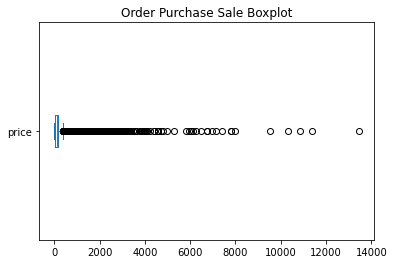

In [18]:
#Data Order Purchase Analysis
plt.figure(figsize=(25,10))
df_sale.plot.box(title='Order Purchase Sale Boxplot', vert=0);
plt.xlabel('')
plt.ylabel('');

In [19]:
df_sale.isnull().sum()

order_purchase_timestamp    0
price                       0
dtype: int64

In [20]:
df_sale = df_sale.set_index('order_purchase_timestamp')
df_sale

,price
order_purchase_timestamp,
2016-09-04 21:15:00,72.89
2016-09-05 00:15:00,59.50
2016-09-13 15:24:00,0.00
2016-09-15 12:16:00,134.97
2016-10-02 22:07:00,100.00
...,...
2018-09-29 09:13:00,0.00
2018-10-01 15:30:00,0.00
2018-10-03 18:55:00,0.00


**TEST OF STATIONARITY**

In [21]:
# Test of stationarity.
# The null hypothesis reject (H0)= the series is not stationary
# If the p-value is less than 0.05, reject H0.

from statsmodels.tsa.stattools import adfuller

result = adfuller(df_sale.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -58.101878
p-value: 0.000000


Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


As p-value is <= 0.05, this means the time series is stationary.


#  **Evolution of E-Commerce Overtime - Total Sales per month**

In [22]:
#Resample time-series data to start month.
previsao = df_sale['price'].resample('MS').sum()
#Fill NA/NaN values using the specified method.
previsao.fillna(df_sale['price'].mean(), inplace=True)

In [23]:
previsao.describe()

count    2.600000e+01
mean     5.465096e+05
std      3.889412e+05
min      0.000000e+00
25%      1.616670e+05
50%      5.733752e+05
75%      9.030802e+05
max      1.046128e+06
Name: price, dtype: float64

In [24]:
previsao.round(2)

order_purchase_timestamp
2016-09-01        267.36
2016-10-01      50942.23
2016-11-01          0.00
2016-12-01         10.90
2017-01-01     128637.99
2017-02-01     260753.86
2017-03-01     396451.04
2017-04-01     391784.42
2017-05-01     545340.65
2017-06-01     453031.41
2017-07-01     533616.84
2017-08-01     601409.67
2017-09-01     662276.39
2017-10-01     693807.60
2017-11-01    1046127.84
2017-12-01     770656.15
2018-01-01     987151.41
2018-02-01     880099.79
2018-03-01    1025936.06
2018-04-01    1029472.30
2018-05-01    1032150.44
2018-06-01     909221.10
2018-07-01     925302.46
2018-08-01     884657.40
2018-09-01        145.00
2018-10-01          0.00
Freq: MS, Name: price, dtype: float64

In [25]:
previsao2 = previsao.drop(labels=['2018-09-01', '2018-10-01'])
previsao3 = previsao2.replace({0.00:5.465096e+05, 10.90:50942.23,145.00:5.465096e+05})
previsao3.round(2)

order_purchase_timestamp
2016-09-01        267.36
2016-10-01      50942.23
2016-11-01     546509.60
2016-12-01      50942.23
2017-01-01     128637.99
2017-02-01     260753.86
2017-03-01     396451.04
2017-04-01     391784.42
2017-05-01     545340.65
2017-06-01     453031.41
2017-07-01     533616.84
2017-08-01     601409.67
2017-09-01     662276.39
2017-10-01     693807.60
2017-11-01    1046127.84
2017-12-01     770656.15
2018-01-01     987151.41
2018-02-01     880099.79
2018-03-01    1025936.06
2018-04-01    1029472.30
2018-05-01    1032150.44
2018-06-01     909221.10
2018-07-01     925302.46
2018-08-01     884657.40
Freq: MS, Name: price, dtype: float64

In [26]:
df = previsao.to_frame()
df2 = previsao3.to_frame()

In [27]:
df2.to_csv("df_st.csv")

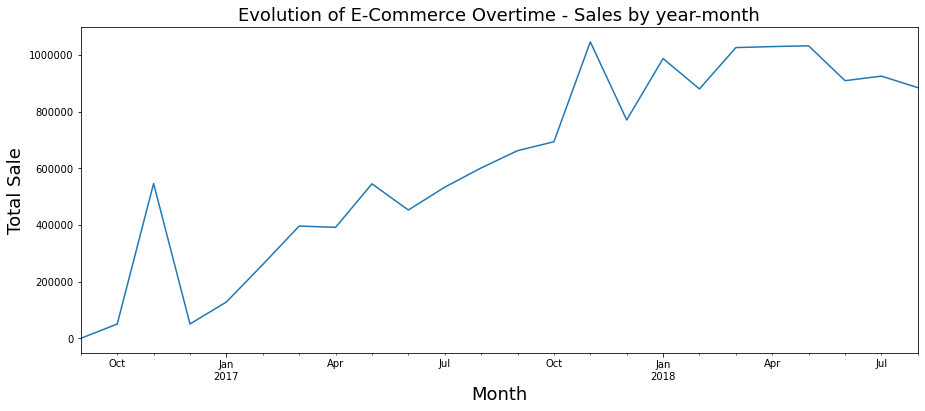

In [28]:
previsao3.plot(figsize=(15, 6))
plt.xlabel("Month", size=18)
plt.ylabel("Total Sale", size=18)
plt.ticklabel_format(style= 'plain', axis='y')
plt.title("Evolution of E-Commerce Overtime - Sales by year-month", fontsize=18);

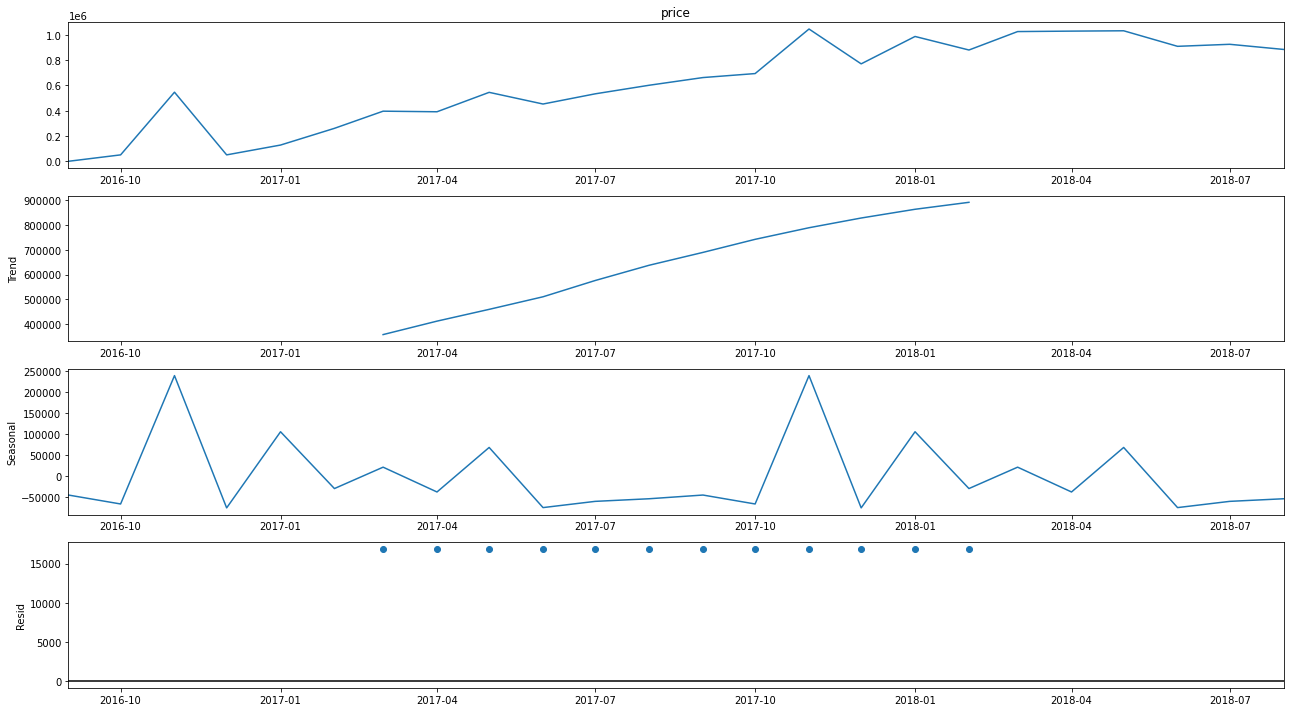

In [29]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(previsao3, model='additive')
fig = decomposition.plot()
plt.show()

# **Dealing with non-stationary series - for order in year-month**

**TEST OF STATIONARITY - AUGMENTED DICKEY FULLER TEST**

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [30]:
# Test of stationarity -  Augmented Dickey Fuller Tes
# The null hypothesis reject (H0)= the series is not stationary
# If the p-value is less than 0.05, reject H0.

from statsmodels.tsa.stattools import adfuller

result=adfuller(previsao3.dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

Teste ADF:-1.7496210288247778
p-valor:0.40574442082547024


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

In [31]:
def stat_test(series):
    stat_test=adfuller(series)
    test_result = pd.Series(stat_test[0:4], index = ['Test statistics', 'p-value', 'Lags Used', 'Number of used observations'])
    print(test_result)

In [32]:
# Log function
log_series_sale = pd.Series(np.log(previsao3.values))
stat_test(log_series_sale)

Test statistics                -3.220997
p-value                         0.018801
Lags Used                       1.000000
Number of used observations    22.000000
dtype: float64


In [33]:
# Differentiating
diff_series = pd.Series(previsao3.diff().values)
diff_series.dropna(inplace = True)
stat_test(diff_series)

Test statistics               -8.287208e+00
p-value                        4.358131e-13
Lags Used                      0.000000e+00
Number of used observations    2.200000e+01
dtype: float64


**As p-value <0.05, the null hypothesis that the diff(series) is not stationary is rejected.**

Now, our time series is stationary. So after these all processes, we can move to the modelling side.

Clearly, the best option regarding this dataset is to apply one differentiating tansformation and predict with it. That is, subtract the previous value from the current value.

Then, the time series reaches stationarity with one order of differencing., that is, d=1.

Let’s see the autocorrelation plot of the differenced series.


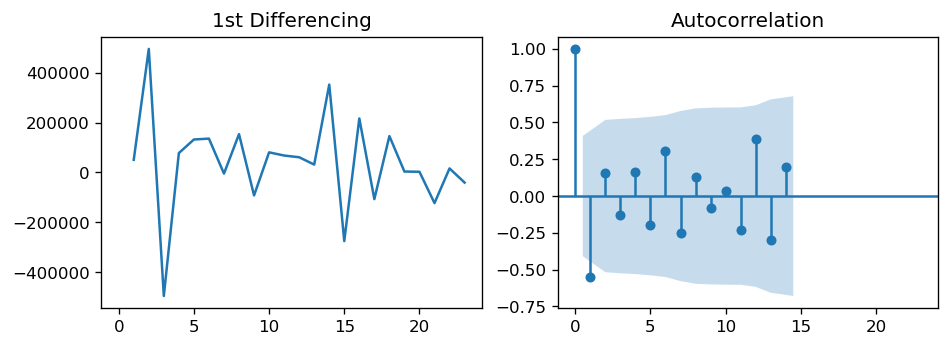

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].plot(diff_series); axes[0].set_title('1st Differencing')
            
plot_acf(diff_series.dropna(), ax=axes[1])

plt.show()

# SARIMA MODEL

In [35]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [36]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(previsao3,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:716.3133827936534
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:712.9446348588144
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:358.77216244018354
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:354.21349932459873
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:714.1941606595367
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:713.8924123552728
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:407.47064562467557
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:350.93002051689336
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:707.1975487790522
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:708.4705452211058
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:347.4083273929271
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:348.7466203843981
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:708.4146737241613
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:710.4145737052502
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:348.5730013320501
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:350.57295590079474
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:627.7548105611229
SARIMAX(0, 1, 0)x(0, 0, 1,

The above output suggests that the SARIMAX(1, 1, 1)x(1, 1, 0, 12)12 produces the lowest AIC value - AIC:288.8718992972772.

                                      SARIMAX Results                                      
Dep. Variable:                               price   No. Observations:                   24
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -140.436
Date:                             Thu, 27 Jan 2022   AIC                            288.872
Time:                                     02:31:48   BIC                            290.463
Sample:                                 09-01-2016   HQIC                           287.869
                                      - 08-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.018    -55.483      0.000      -1.035      -0.965
ma.L1          1.0022      

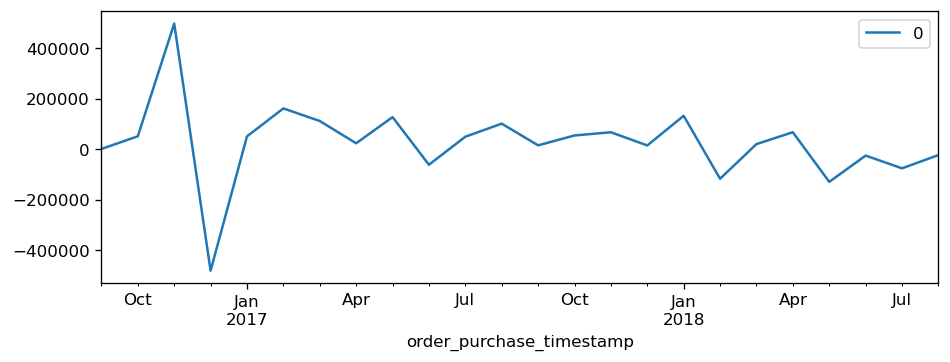

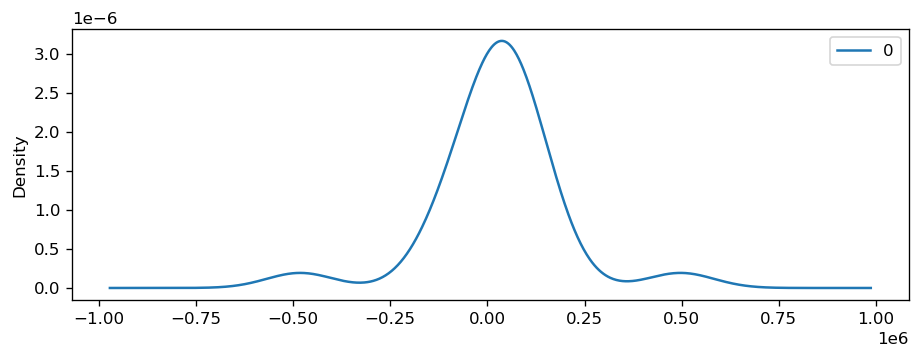

                   0
count      24.000000
mean    25782.875464
std    162558.013770
min   -482142.897048
25%    -24304.496432
50%     35869.977343
75%     75141.885194
max    497134.726240


In [37]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame

model_sarimax_previsao = SARIMAX(previsao3, order=(1,1,1), seasonal_order=(1,1,0,12), enforce_invertibility=False)
resultado_sarimax_previsao = model_sarimax_previsao.fit()
# summary of fit model
print(resultado_sarimax_previsao.summary())
resultado_sarimax_previsao.summary()

# line plot of residuals
residuals_previsao = DataFrame(resultado_sarimax_previsao.resid)
residuals_previsao.plot()
plt.show()
# density plot of residuals
residuals_previsao.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals_previsao.describe())

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

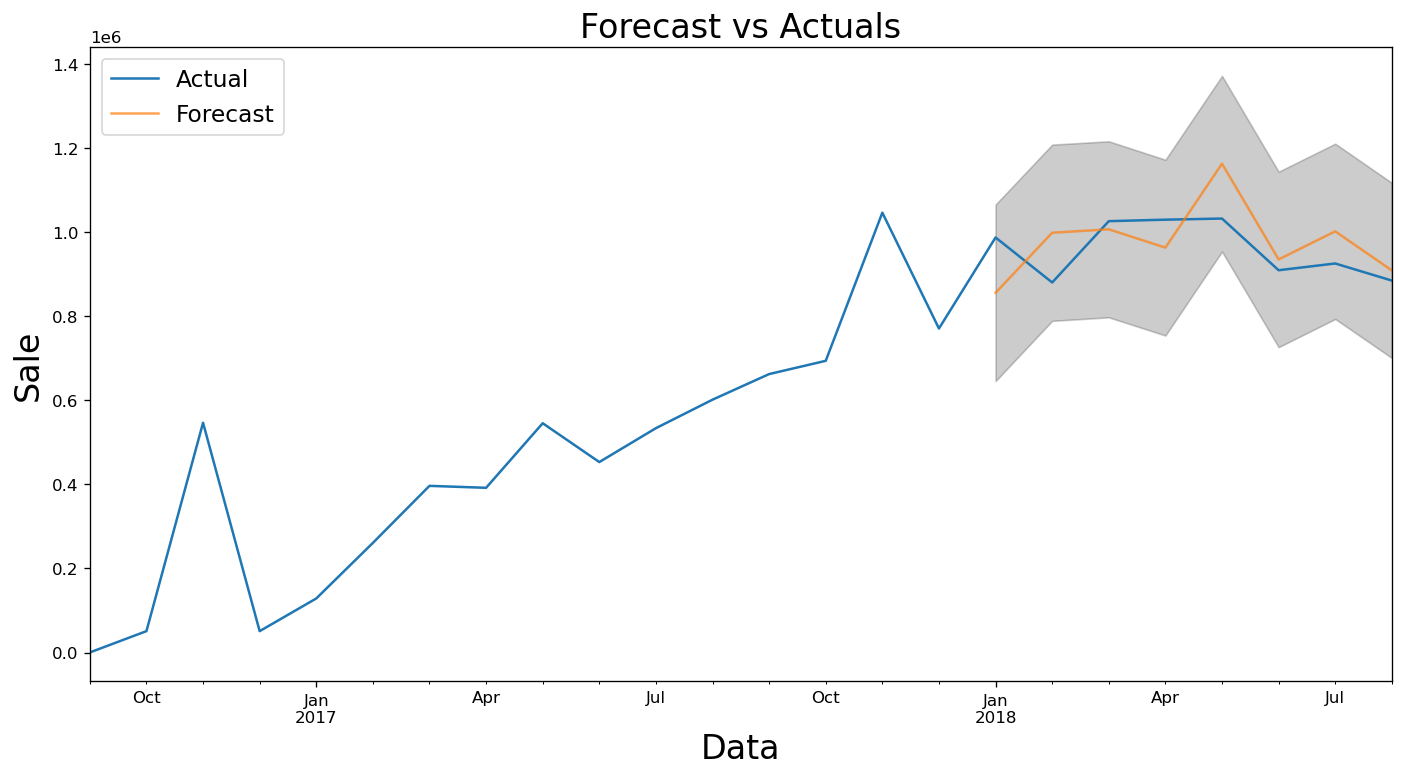

In [38]:
# VALIDATING THE FORECAST

pred_previsao = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred_previsao.conf_int()
ax = previsao3['2016':].plot(label='Actual')
pred_previsao.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data', fontsize=20)
ax.set_ylabel('Sale', fontsize=20)
plt.title('Forecast vs Actuals', fontsize=20)
plt.legend(loc='upper left', fontsize=14)
plt.show()

From the chart, the SARIMAX(0, 1, 0)x(0, 1, 0, 12) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

In [39]:
previsao_forecasted = pred_previsao.predicted_mean
previsao3_truth = previsao3['2018-01-01':]
mse = ((previsao_forecasted - previsao3_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 7526998804.9


In [40]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 86758.28


In [41]:
#performance
time_series_month = ml_error('Sarimax Sales by Month', previsao_forecasted, previsao3_truth)
time_series_month.round(2)

,Model Name,r2,MAE,MAPE,RMSE,MSE
0,Sarimax Sales by Month,-0.04,74069.79,0.08,86758.28,7.526999e+09


# 🔮 FINAL FORECAST - BY MONTH

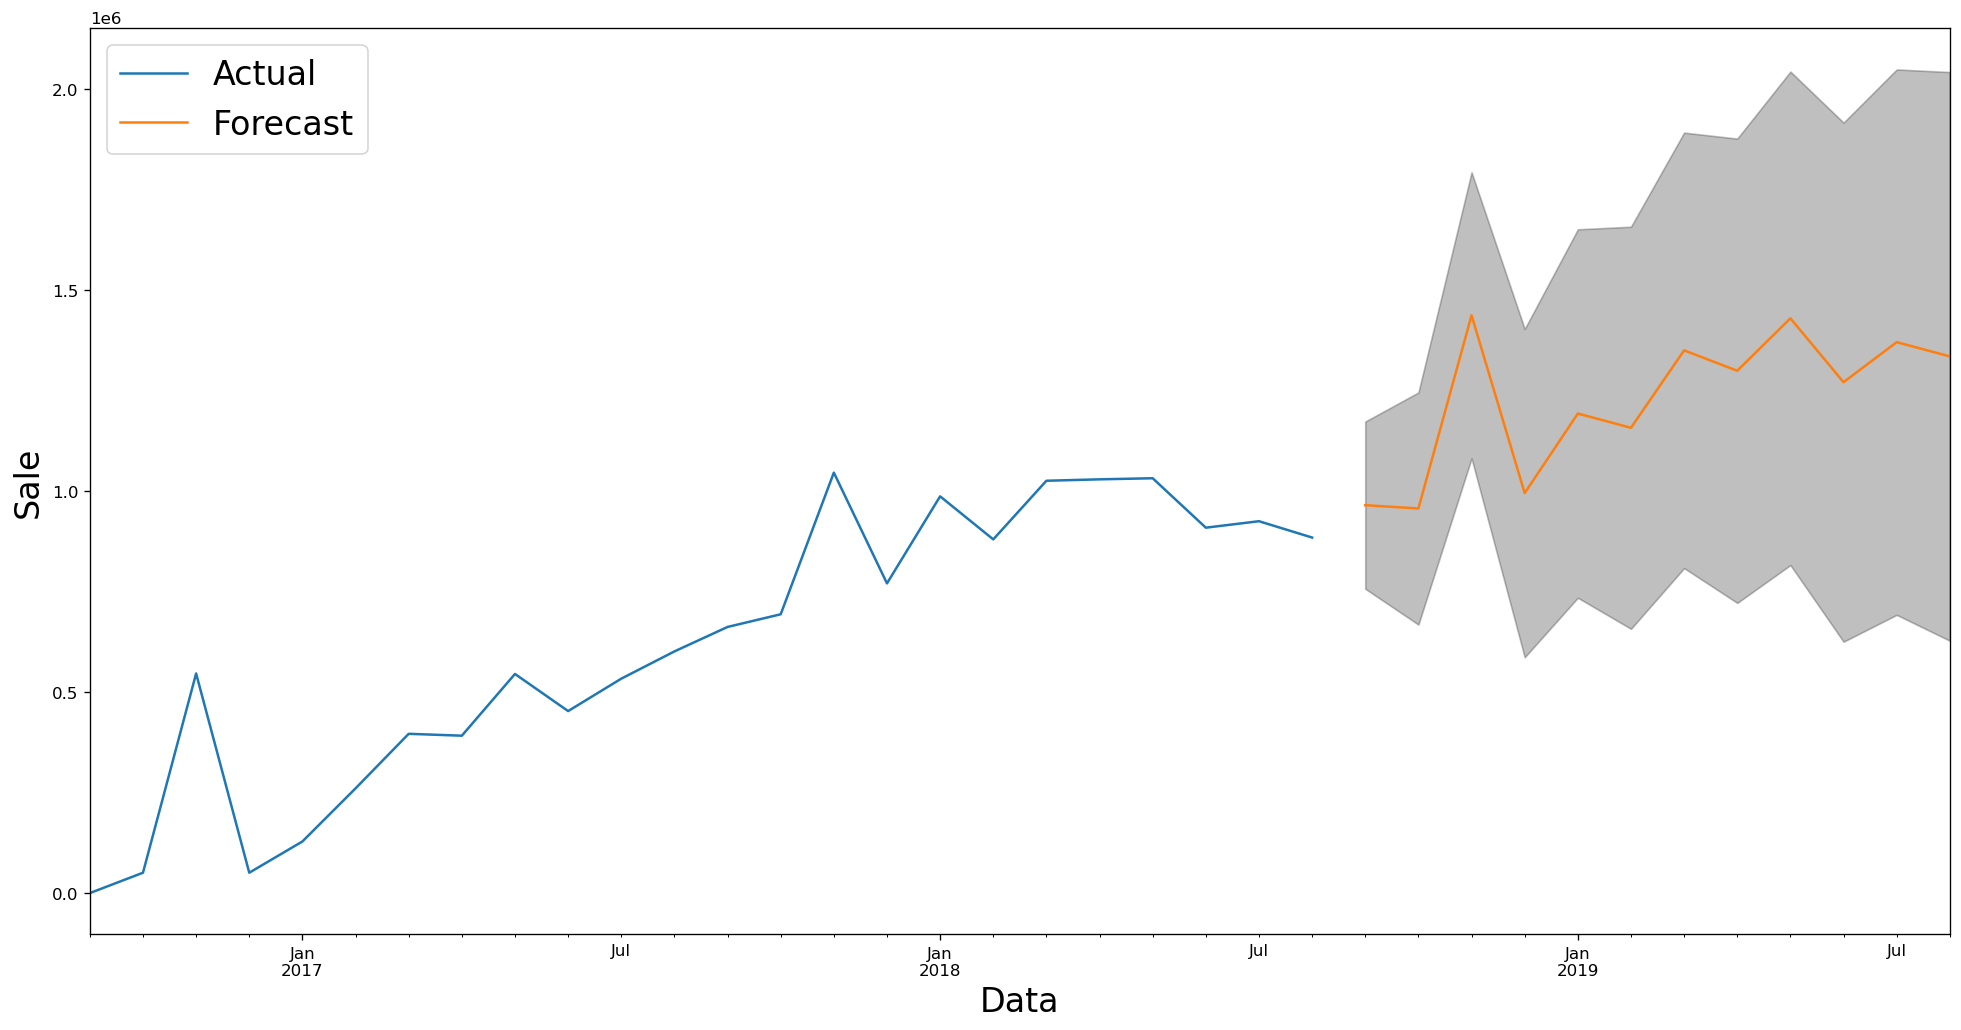

In [42]:
# Let’s forecast for the next 12 months.

pred_uc = results.get_forecast(steps=12)
pred_ci2 = pred_uc.conf_int()
ax = previsao3.plot(label='Actual', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data', fontsize=20)
ax.set_ylabel('Sale', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.show()

# **Evolution of E-Commerce Overtime - Total Sales per week**

In [43]:
#Resample time-series data to start month.
previsao4 = df_sale['price'].resample('W-MON').sum()
previsao4.fillna(df_sale['price'].mean(), inplace=True)

In [44]:
previsao4.round(2)

order_purchase_timestamp
2016-09-05    132.39
2016-09-12      0.00
2016-09-19    134.97
2016-09-26      0.00
2016-10-03    563.48
               ...  
2018-09-24      0.00
2018-10-01      0.00
2018-10-08      0.00
2018-10-15      0.00
2018-10-22      0.00
Freq: W-MON, Name: price, Length: 112, dtype: float64

In [45]:
previsao5=previsao4.iloc[:-8]
previsao_w = previsao5.replace({0.000000: 127443.746875, 10.900000:127443.746875})

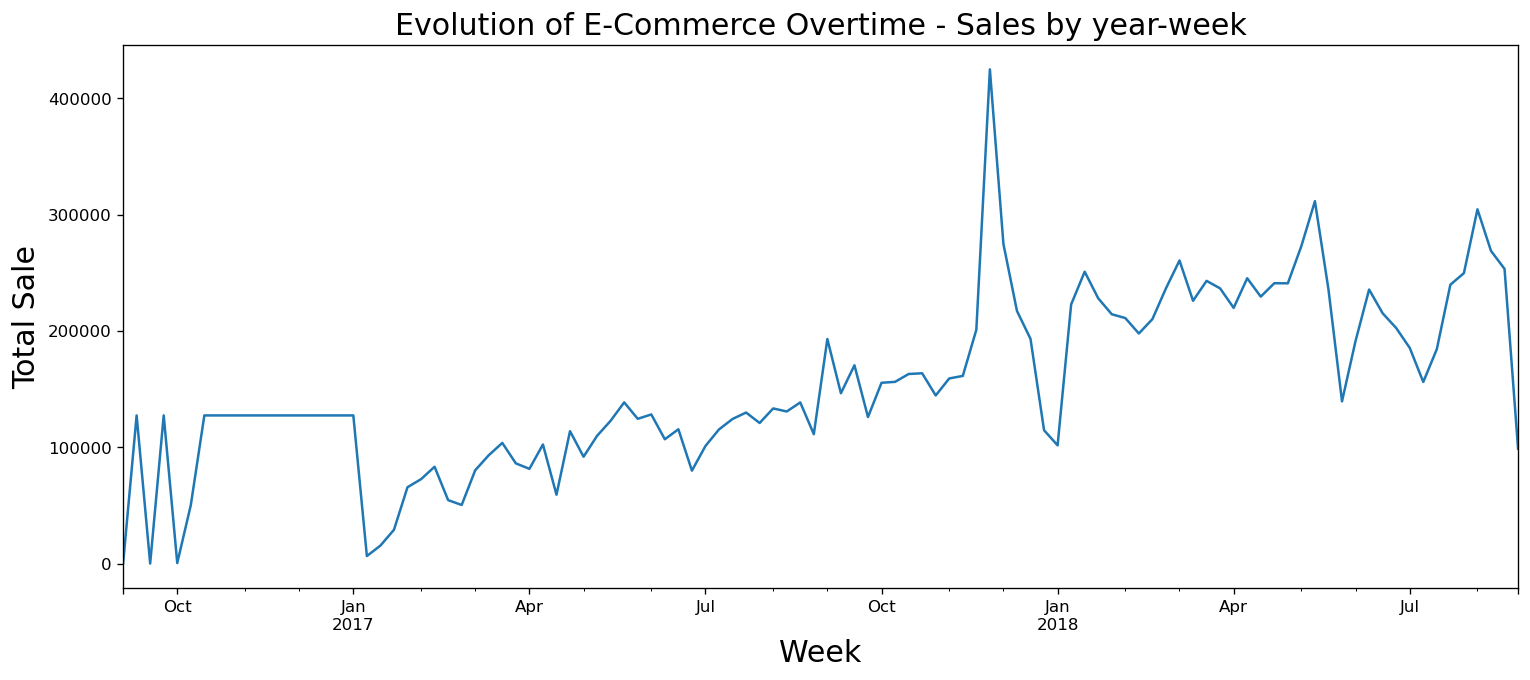

In [46]:
previsao_w.plot(figsize=(15, 6))
plt.xlabel("Week", size=18)
plt.ylabel("Total Sale", size=18)
plt.title("Evolution of E-Commerce Overtime - Sales by year-week", fontsize=18)
plt.show()

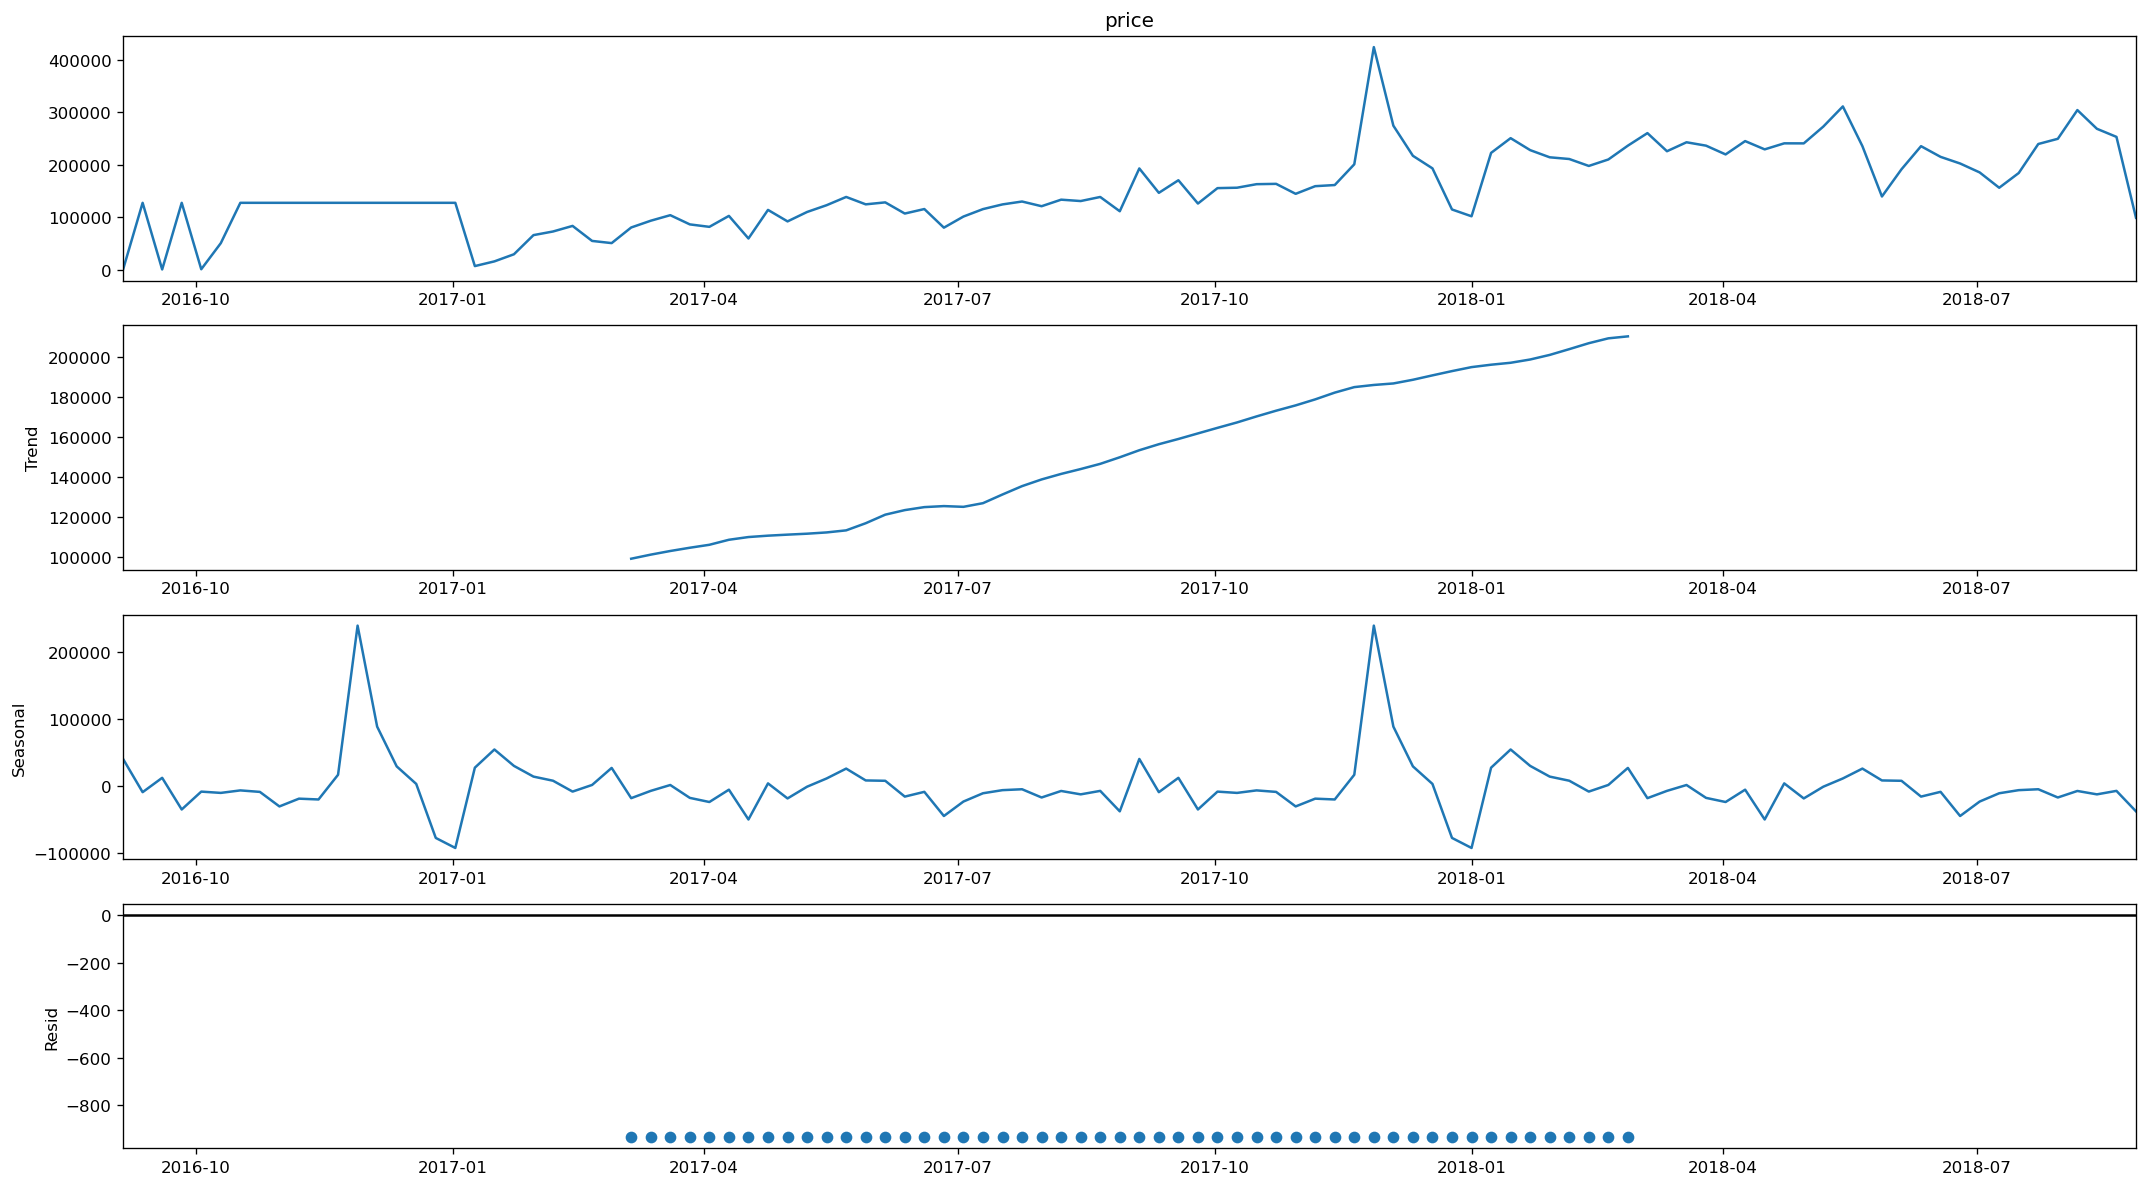

In [47]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(previsao_w, model='additive')
fig = decomposition.plot()
plt.show()

# Dealing with non-stationary series - for order in year-month

In [48]:
# Test of stationarity.
# The null hypothesis reject (H0)= the series is not stationary
# If the p-value is less than 0.05, reject H0.

from statsmodels.tsa.stattools import adfuller

result=adfuller(previsao_w.dropna())
print(f'Teste ADF:{(result[0])}')
print(f'p-valor:{result[1]}')

Teste ADF:-1.6884808723401898
p-valor:0.4370570369415179


As p-value >0.05, the null hypothesis that the monthly sales series is not stationary is not rejected. Then, we need apply other transformation techniques before applying SARIMAX models

In [49]:
# Differentiating
diff_seriesw = pd.Series(previsao_w.diff().values)
diff_seriesw.dropna(inplace = True)
stat_test(diff_seriesw)

Test statistics               -7.874265e+00
p-value                        4.891556e-12
Lags Used                      4.000000e+00
Number of used observations    9.800000e+01
dtype: float64


**As p-value <0.05, the null hypothesis that the diff(series) is not stationary is rejected.**

Now, our time series is stationary. So after these all processes, we can move to the modelling side.

Clearly, the best option regarding this dataset is to apply one differentiating tansformation and predict with it. That is, subtract the previous value from the current value.

Then, the time series reaches stationarity with one order of differencing., that is, d=1.

Let’s see the autocorrelation plot of the differenced series.

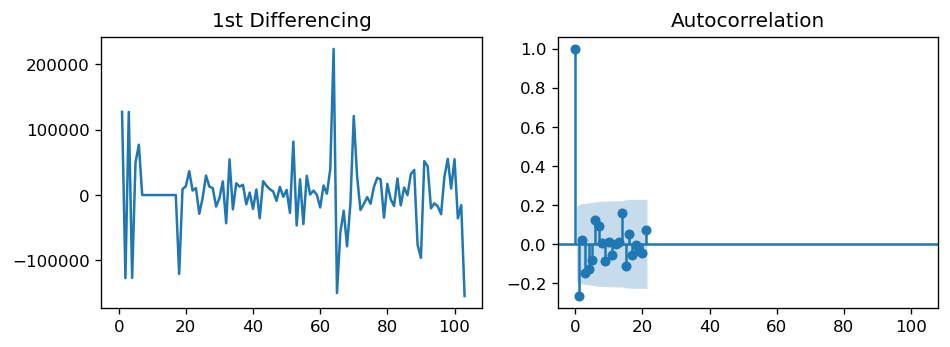

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].plot(diff_seriesw); axes[0].set_title('1st Differencing')
            
plot_acf(diff_seriesw.dropna(), ax=axes[1])

plt.show()

# SARIMA MODEL

In [51]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            modweek = sm.tsa.statespace.SARIMAX(previsao_w,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = modweek.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2803.436958669239
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2775.2651753861933
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2316.088839880103
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2305.4997809689826
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2637.180961470998
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2633.729448809311
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2303.3110828847593
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2305.180244572124
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2740.259477053753
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2729.0099159783904
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2294.009172640875
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2278.4751051414373
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2722.8920729410456
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2724.0172978084274
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2277.967438901827
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2279.1724882251906
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2530.467345588573
SARIMAX(0, 1, 0)x(0, 0,

The above output suggests that the SARIMAX(1, 1, 1)x(0, 1, 1, 12)12 produces the lowest AIC:2241.64508769589

                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                  104
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1116.823
Date:                            Thu, 27 Jan 2022   AIC                           2241.645
Time:                                    02:31:54   BIC                           2251.689
Sample:                                09-05-2016   HQIC                          2245.697
                                     - 08-27-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4394      0.248      1.775      0.076      -0.046       0.925
ma.L1         -0.8823      0.192   

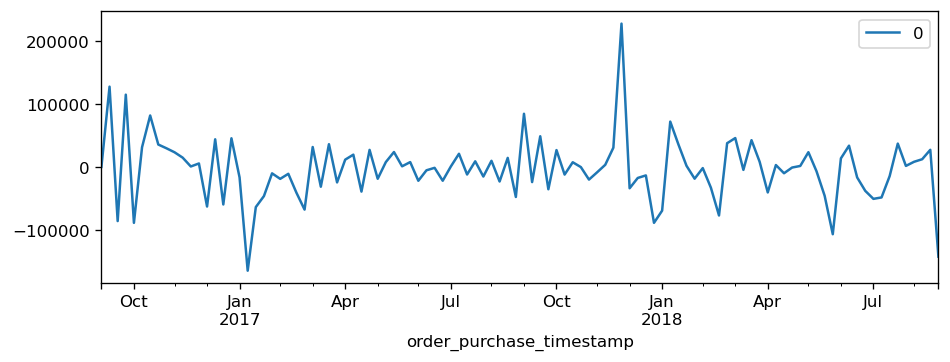

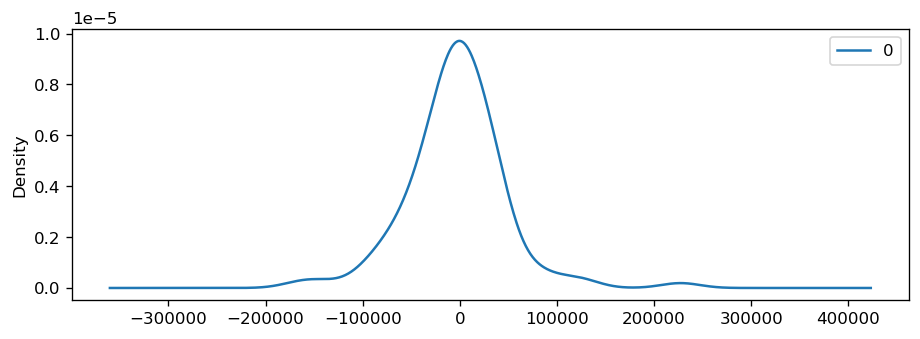

                   0
count     104.000000
mean    -3487.872743
std     50579.237169
min   -164438.321928
25%    -24059.881871
50%      -511.289310
75%     23337.301947
max    227290.392570


In [52]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame


model_sarimax_previsao = SARIMAX(previsao_w, order=(1,1,1), seasonal_order=(0,1,1,12), enforce_invertibility=False)
resultado_sarimax_previsao = model_sarimax_previsao.fit()
# summary of fit model
print(resultado_sarimax_previsao.summary())
resultado_sarimax_previsao.summary()

# line plot of residuals
residuals_previsao = DataFrame(resultado_sarimax_previsao.resid)
residuals_previsao.plot()
plt.show()
# density plot of residuals
residuals_previsao.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals_previsao.describe())

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

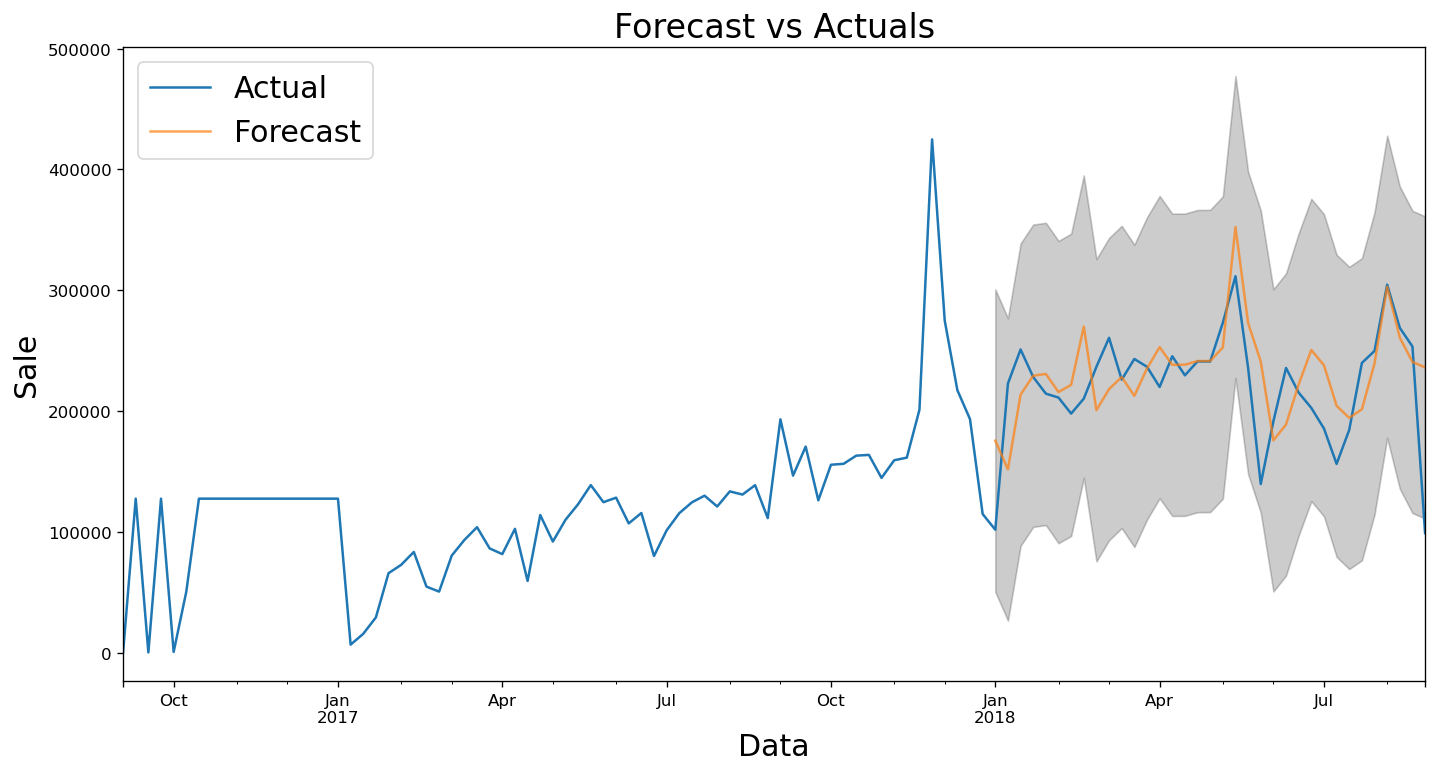

In [53]:
# VALIDATING THE FORECAST - weekly

pred_w = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred_w.conf_int()
ax = previsao_w['2016':].plot(label='Actual')
pred_w.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Sale', fontsize=18)
plt.title('Forecast vs Actuals', fontsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

In [54]:
previsao_forecastedw = pred_w.predicted_mean
previsao_w_truth = previsao_w['2018-01-01':]
mse = ((previsao_forecastedw - previsao_w_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1882710026.47


In [55]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 43390.21


The commonly used accuracy metrics to judge forecasts were presented below:

1. Mean Absolute Error (MAE)
2. Mean Absolute Percentage Error (MAPE)
3. Root Mean Squared Error (RMSE)
4. Mean Squared Error (MSE)

In [56]:
#performance
time_series_week = ml_error('Sarimax Sales by Week', previsao_forecastedw, previsao_w_truth)
time_series_week.round(2)

,Model Name,r2,MAE,MAPE,RMSE,MSE
0,Sarimax Sales by Week,-0.45,31027.23,0.14,43390.21,1.882710e+09


In [57]:
#performance
time_series_month = ml_error('Sarimax Sales by Month', previsao_forecasted, previsao3_truth)
time_series_month.round(2)

,Model Name,r2,MAE,MAPE,RMSE,MSE
0,Sarimax Sales by Month,-0.04,74069.79,0.08,86758.28,7.526999e+09


The mean absolute percentage error (MAPE) metric is is less for prediction with monthly periodicity. However, root mean squared error (RMSE) is less for the weekly evaluation than for the monthly evaluation.

# 🔮 FINAL FORECAST - BY WEEK

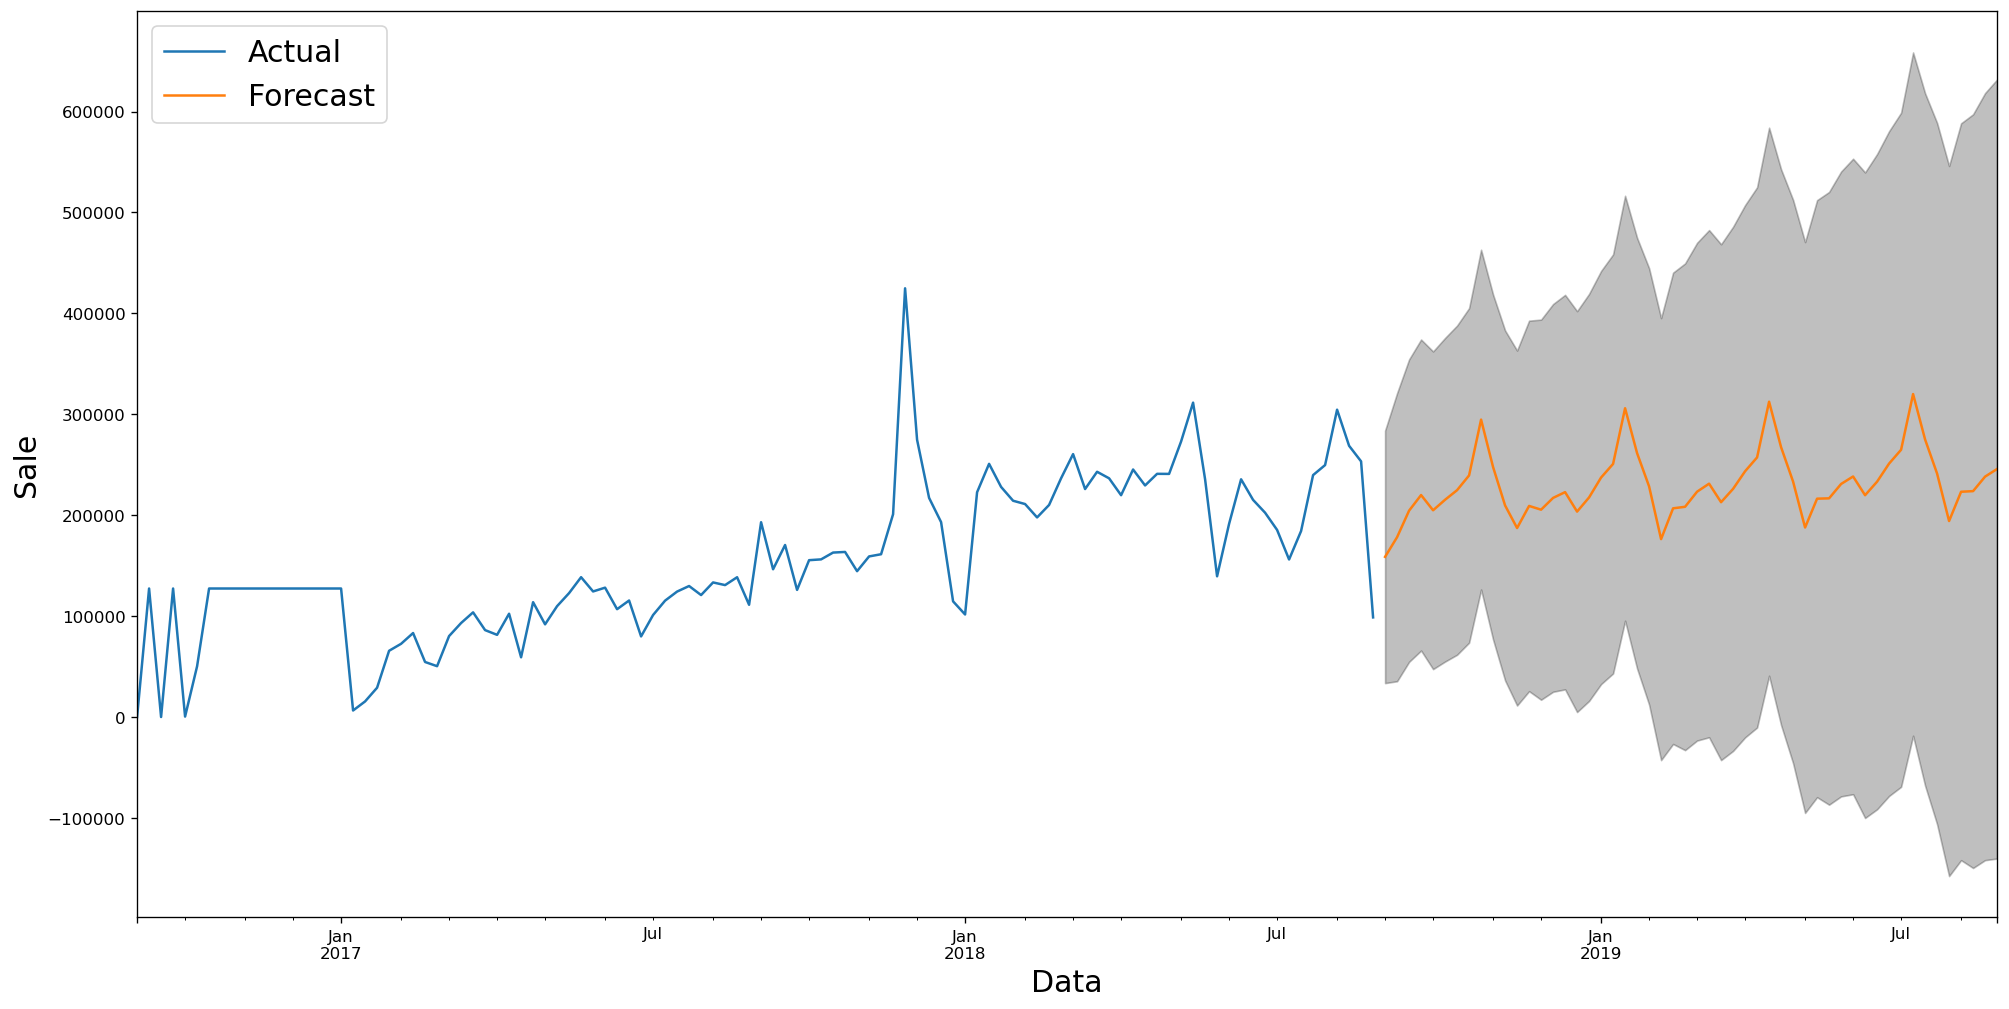

In [58]:
# # Let’s forecast for the next 52 weeks.

pred_uc = results.get_forecast(steps=52)
pred_ci2 = pred_uc.conf_int()
ax = previsao_w.plot(label='Actual', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Sale', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.show()

# **Customer's State Distribution**

**CONVERT DATE COLUMNS TO TIMESTAMP**

In [59]:
# Changing the datetime features to the correct format
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
                  
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
#df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))


df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m-%d'))

# Extracting attributes for purchase date - Year and Week
df_orders['order_purchase_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.week)
df_orders['order_purchase_year_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%U'))


# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))


# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_year_month,order_purchase_date,order_purchase_week,order_purchase_year_week,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,2017-10,2017-10-02,40,2017-40,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,2018-08-07 15:27:00,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,2018-07,2018-07-24,30,2018-29,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,2018-08-17 18:06:00,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,2018-08,2018-08-08,32,2018-31,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,2017-11-18 19:45:00,2017-11-22 13:39:00,2017-12-02 00:28:00,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,2017-11,2017-11-18,46,2017-46,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,2018-02-13 22:20:00,2018-02-14 19:46:00,2018-02-16 18:17:00,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,2018-02,2018-02-13,7,2018-06,13,1,Tue,21,Night


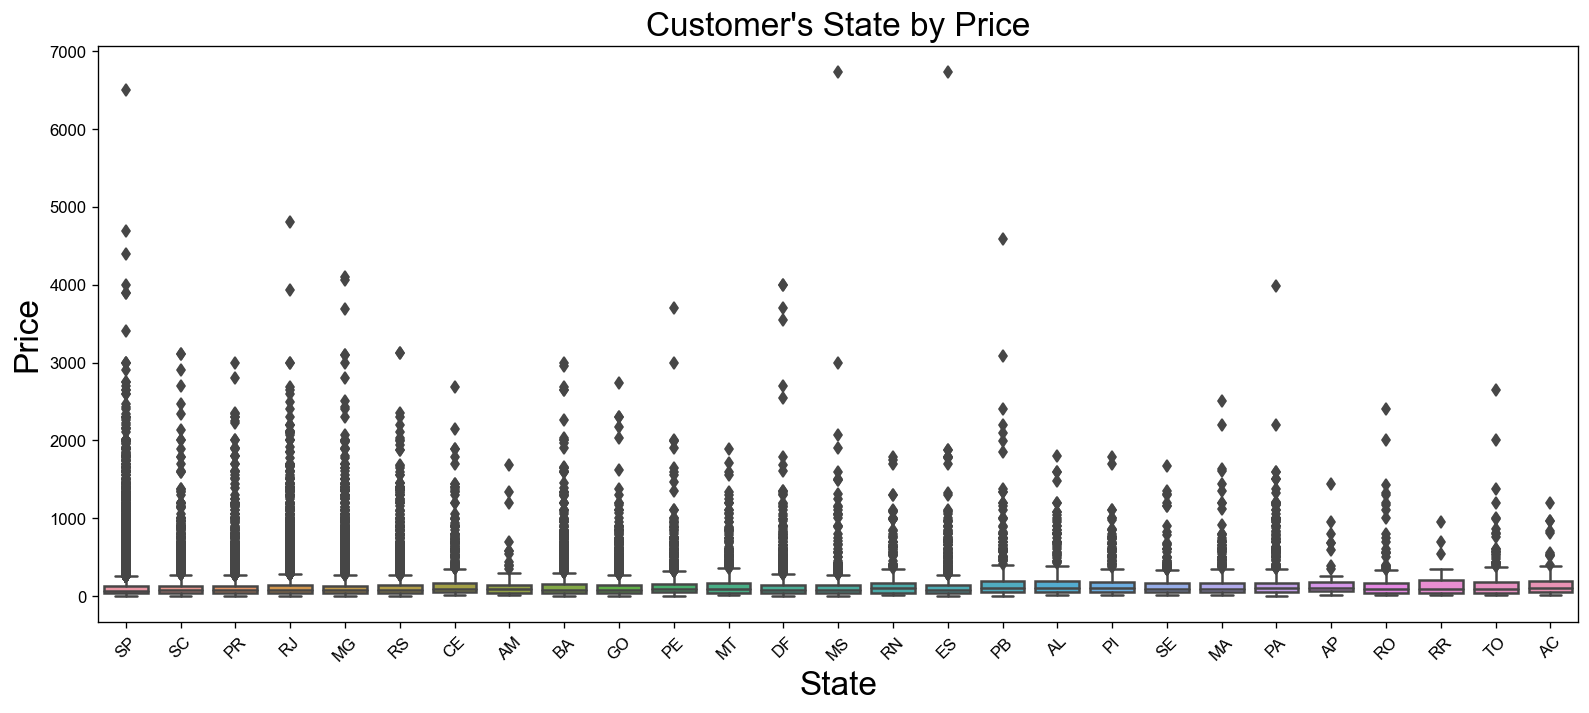

In [60]:
plt.figure(figsize=(35,14))

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price', 
                 data=df_train[df_train['price'] != -1])
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

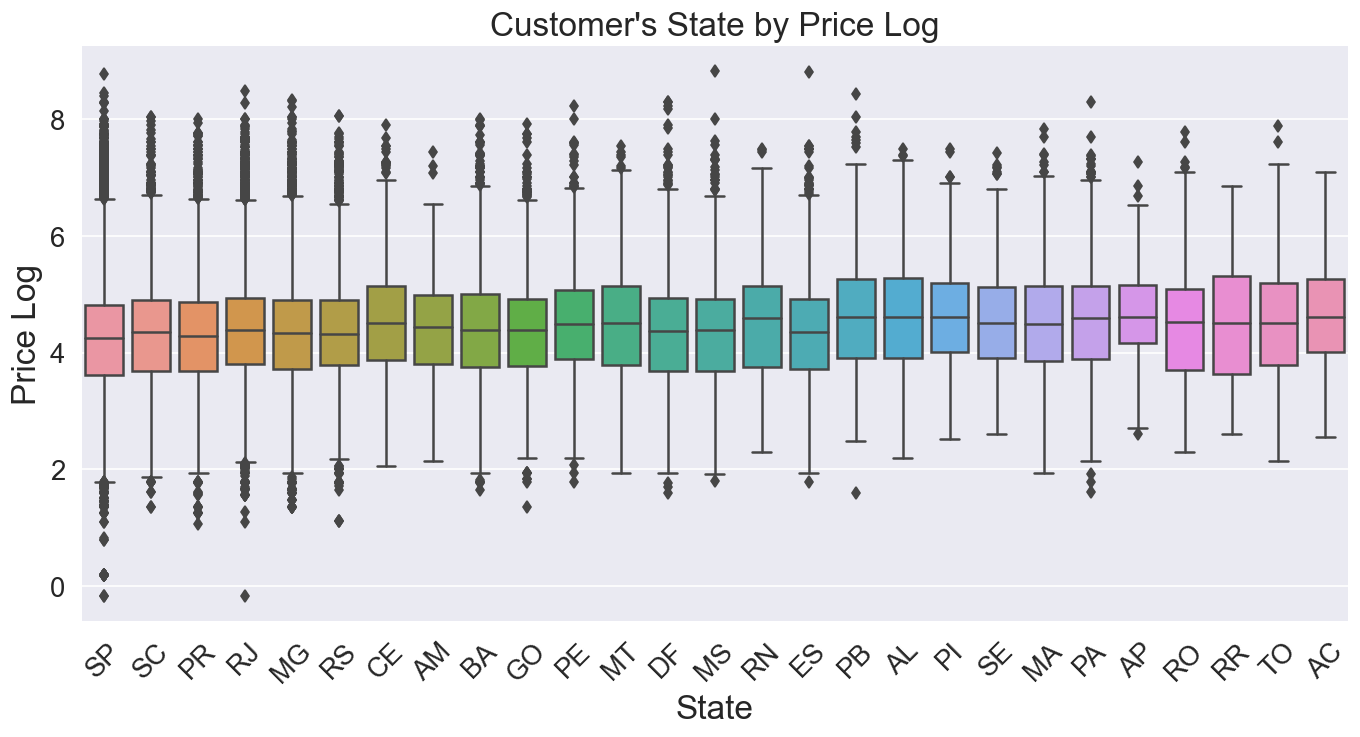

In [61]:
plt.figure(figsize=(30,14))
df_train['price_log'] = np.log(df_train['price'])

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=df_train[df_train['price'] != -1])
g2.set_title("Customer's State by Price Log", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price Log", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

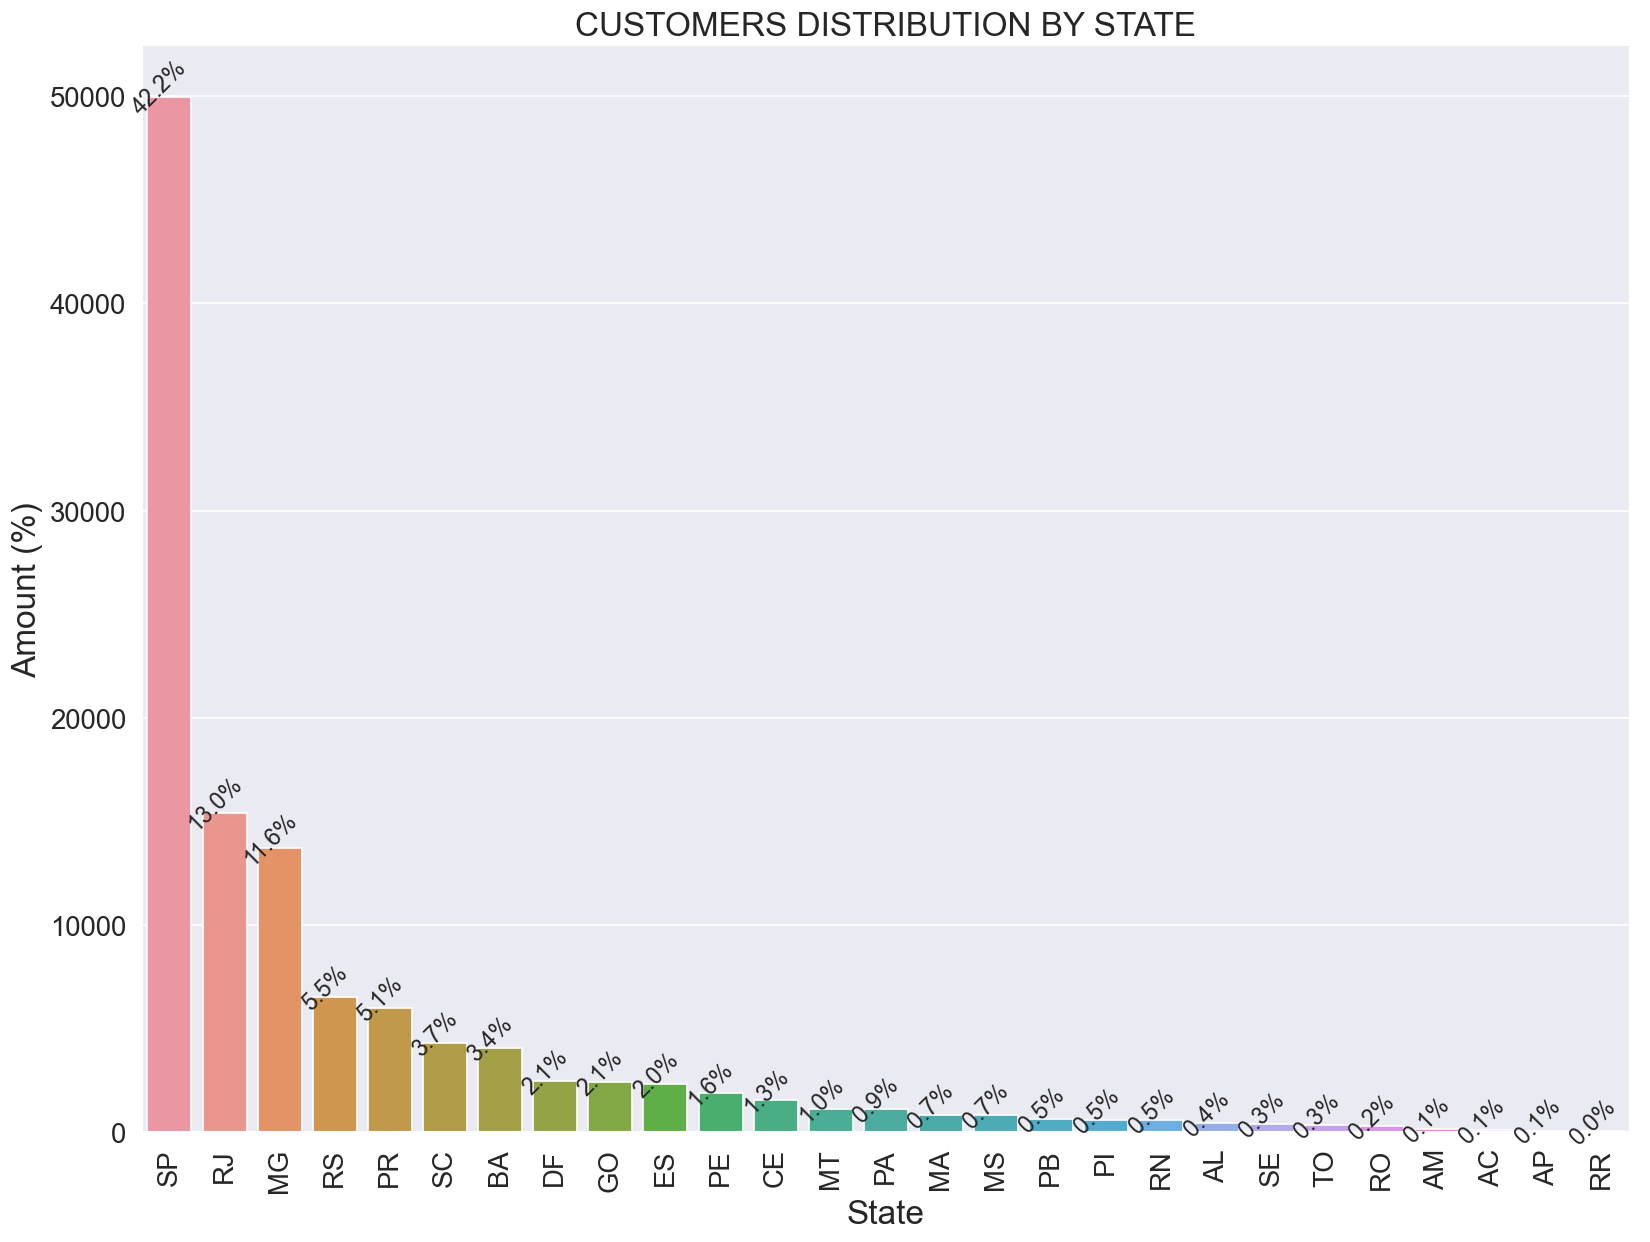

In [62]:
plt.figure(figsize=(16,12))

ax = sns.countplot(x='customer_state', data=df_train, orient='h', order=df_train['customer_state'].value_counts().index)
ax.set_title("CUSTOMERS DISTRIBUTION BY STATE", fontsize=20)
ax.set_xlabel("State", fontsize=20)
ax.set_ylabel("Amount (%)", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sizes = []
total=len(df_train)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=14, rotation=45)
    

plt.show()

# **References:**

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python

https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp

https://www.linkedin.com/pulse/previs%25C3%25A3o-de-vendas-com-an%25C3%25A1lise-s%25C3%25A9ries-temporais-everton-s-paula/?trackingId=fRvgTUaEQCmaZhLGDBdG7A%3D%3D

https://github.com/ledmaster/notebooks_tutoriais/blob/master/live12_timeseries_prophet/nb1.ipynb

https://facebook.github.io/prophet/docs/quick_start.html#python-api

https://github.com/Pedro-Prestes/learning/blob/master/Aula_010_S%C3%A9ries_Temporais_com_Prophet.ipynb